# <b>CS156 (Introduction to AI), Spring 2021</b>
# <u><b>Homework 9 submission</b></u>

### Roster Name: David Wang
### Student ID: 012368967
### Email address: davidwangdn@gmail.com


##  <u>References and sources </u>

CNN.Dog_vs_cat_images.ipynb

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from sklearn.metrics import plot_confusion_matrix

In [3]:
np.random.seed(42)

#### Code the solution

In [4]:
num_skipped = 0
for folder_name in ("daisy", "dandelion", "rose", "sunflower", "tulip"):
    folder_path = os.path.join("/Users/davidwang/CS 156/flowers/training", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/davidwang/CS 156/flowers/training",
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode='categorical',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/davidwang/CS 156/flowers/training",
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode='categorical',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/davidwang/CS 156/flowers/test",
    seed=42,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=1,
)

Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

In [9]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
87/87 [==============================] - 311s 4s/step - loss: 1.3611 - accuracy: 0.5030 - val_loss: 1.7105 - val_accuracy: 0.2590
Epoch 2/10
87/87 [==============================] - 303s 3s/step - loss: 1.0840 - accuracy: 0.5912 - val_loss: 2.2653 - val_accuracy: 0.2590
Epoch 3/10
87/87 [==============================] - 273s 3s/step - loss: 0.9204 - accuracy: 0.6670 - val_loss: 3.0661 - val_accuracy: 0.2590
Epoch 4/10
87/87 [==============================] - 284s 3s/step - loss: 0.8208 - accuracy: 0.6916 - val_loss: 3.6516 - val_accuracy: 0.2590
Epoch 5/10
87/87 [==============================] - 278s 3s/step - loss: 0.7766 - accuracy: 0.7175 - val_loss: 3.6973 - val_accuracy: 0.2590
Epoch 6/10
87/87 [==============================] - 276s 3s/step - loss: 0.7503 - accuracy: 0.7204 - val_loss: 2.1616 - val_accuracy: 0.3227
Epoch 7/10
87/87 [==============================] - 277s 3s/step - loss: 0.7016 - accuracy: 0.7365 - val_loss: 1.1264 - val_accuracy: 0.6237
Epoch 8/10
87

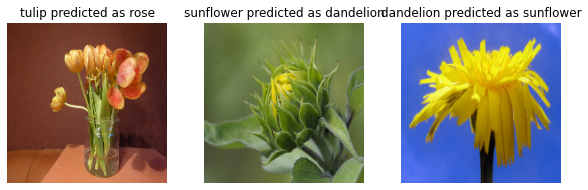

In [52]:
predictList = []
trueList = []
i = 0
plt.figure(figsize=(10, 10))
class_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
for x,y in test_ds:
    prediction = model.predict(x)
    P = np.argmax(prediction)
    predictList.append(P)
    T = np.argmax(y)
    trueList.append(T)
    if (P != T) and (i < 3):
        titleName = class_names[T] + " predicted as " + class_names[P]
        ax = plt.subplot(3, 3,  i + 1)
        plt.imshow(x[0].numpy().astype("uint8"))
        plt.title(titleName)
        plt.axis("off")
        i = i + 1


In [24]:
conmatrix = tf.math.confusion_matrix(labels=true, predictions=predict).numpy()

In [28]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

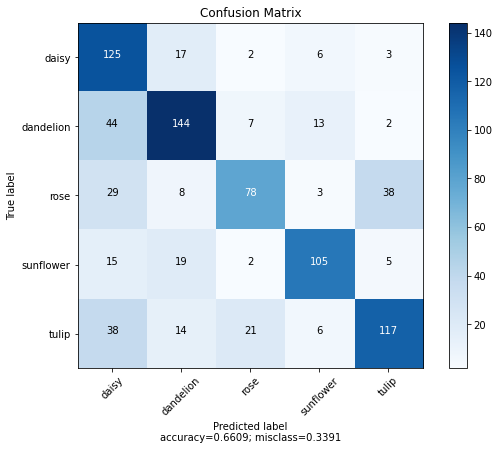

In [30]:
plot_confusion_matrix(cm = conmatrix,
                      normalize    = False,
                      target_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"],
                      title        = "Confusion Matrix")